In [1]:
#meta 2/7/2021 Kaggle Cassava Module 1-Model Mini (for rapid iteration)
#fast.ai 2020 study group Kaggle Competition
#src https://www.kaggle.com/c/cassava-leaf-disease-classification
#prev competition src https://www.kaggle.com/c/cassava-disease
#references https://arxiv.org/pdf/1908.02900.pdf

#input: exported data files from my-cassava-data-v2-mini10pct
#output: model artifacts, submission.csv
#pwd: /kaggle/working
#based on version of my-kaggle-cassava-1-model.ipynb -> my-kaggle-cassava-1-model_bs56_score0881.ipynb

#prev in my-kaggle-cassava-1-model_bs56_score0881.ipynb
#1/23/2021 MODULE 1-MODEL FULL W/ INFERENCE + EXPORT
#      $params: DEBUG = 0, DS_OVERSAMPLED = 0
#      in FULL mode, train entire ds (not oversampled) (exported from Module 0), export model
#      Score: .881  Time: 94min + submission time, Rank: n/a
#      Note: Same model V2bs56 submitted with TTA scored only .884 and .881
#      Best Score so far: .889 (v52) with TTA.

#history
#2/7/2021 MODULE 1-MODEL MINI W/ INFERENCE + EXPORT, DELTA BS=64
#      $params: MINI = 1, DS_OVERSAMPLED = 0
#      in MINI mode, train mini ds (not oversampled) (exported from Module 0)
#      dataprep: splitter=ColSplitter(), item_tfms = None, batch_tfms = [ *aug_transforms(flip_vert=True, max_zoom=3.0), Normalize.from_stats(*imagenet_stats)])
#                bs=64
#      model: learn = cnn_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
#      learn.fine_tune(15)
#      preds,_ = learn.get_preds(dl=test_dl), no TTA
#      Score: .812  Time: 10min + submission time, Rank: n/a

#2/7/2021 MODULE 1-MODEL MINI W/ INFERENCE + EXPORT, DELTA BS=32 per Yann LeCunn advice
#      $params: MINI = 1, DS_OVERSAMPLED = 0
#      in MINI mode, train mini ds (not oversampled) (exported from Module 0)
#      dataprep: splitter=ColSplitter(), item_tfms = None, batch_tfms = [ *aug_transforms(flip_vert=True, max_zoom=3.0), Normalize.from_stats(*imagenet_stats)])
#                bs=32
#      model: learn = cnn_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
#      learn.fine_tune(15)
#      preds,_ = learn.get_preds(dl=test_dl), no TTA
#      Score: .822 and .825  Time: 10min + submission time, Rank: n/a

#here 2/13/2021 MODULE 1-MODEL MINI W/ INFERENCE + EXPORT, DELTA Resnet50 bs=16
#      $params: MINI = 1, DS_OVERSAMPLED = 0
#      in MINI mode, train mini ds (not oversampled) (exported from Module 0)
#      dataprep: splitter=ColSplitter(), item_tfms = None, batch_tfms = [ *aug_transforms(flip_vert=True, max_zoom=3.0, max_lighting=0.3), Normalize.from_stats(*imagenet_stats)])
#                bs=16
#      model: learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
#      learn.fine_tune(15)
#      preds,_ = learn.get_preds(dl=test_dl), no TTA
#      Score: .?  Time: ?min + submission time, Rank: n/a


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import os
import time #to track performance time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#modeling
from fastai.vision.all import *


# Input data files are available in the read-only "../input/" directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
#--constants and variables
SEED = 24 
MINI = 1 #$params
DS_OVERSAMPLED = 0 #$params
BATCH_SIZE = 16 #$params
N_EPOCHS_FULL = 15 #$params
N_EPOCHS_MINI = 15 #$params
N_EPOCHS_FREEZE = 3 #$params

#set paths
path = Path('../input/cassava-leaf-disease-classification')
path_data = Path('../input/my-cassava-data-v2-mini10pct')

#--functions
def get_x(row): return path/'train_images'/row['image_id']
def get_y(row): return row['label']


# Cassava Disease Classification
##### Objective: Classify pictures of cassava leaves into 1 of 4 disease categories or healthy.

Mini mode for rapid iteration


## 0. Load Data


### 0.1 Images  
21397 train images and 1 test image

In [4]:
#(path/'train_images').ls(), (path/'test_images').ls()

In [5]:
#load train/test images
#train_img = get_image_files(path/'train_images')
#test_img = get_image_files(path/'test_images')

#print("Number of files: ", (len(train_img), len(test_img)))

### 0.3 Train Dataset
Export from module 0-Data

In [6]:
#$param
if MINI:
    if DS_OVERSAMPLED:
        df_train = torch.load(path_data/'df_train_os_mini.pkl')
    else:
        df_train = torch.load(path_data/'df_train_mini.pkl')
else:
    if DS_OVERSAMPLED:
        df_train = torch.load(path_data/'df_train_os.pkl')
    else:
        df_train = torch.load(path_data/'df_train.pkl')
        
print('train data\n', df_train.shape)
display(df_train.head())

train data
 (2140, 4)


,index,image_id,label,is_valid
0,19,1003987001.jpg,3,1
1,23,1004672608.jpg,3,0
2,24,100472565.jpg,2,0
3,27,1005138819.jpg,3,0
4,42,1008244905.jpg,1,0


0     109
1     219
2     238
3    1316
4     258
Name: label, dtype: int64


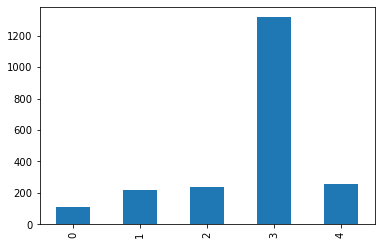

In [7]:
print(df_train['label'].value_counts().sort_index())
df_train['label'].value_counts().sort_index().plot(kind='bar');

## 1. Prep Data


### 1.1 From Data to Dataloaders
with DataBlock

In [8]:
#dataloaders
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_x = get_x,
                 get_y = get_y,
                 splitter=ColSplitter(), 
                 item_tfms = None, 
                 batch_tfms = [ *aug_transforms(flip_vert=True, max_zoom=3.0), Normalize.from_stats(*imagenet_stats)])
#                      

dls = dblock.dataloaders(df_train, bs=BATCH_SIZE)

len(dls.train_ds), len(dls.valid_ds)

(1712, 428)

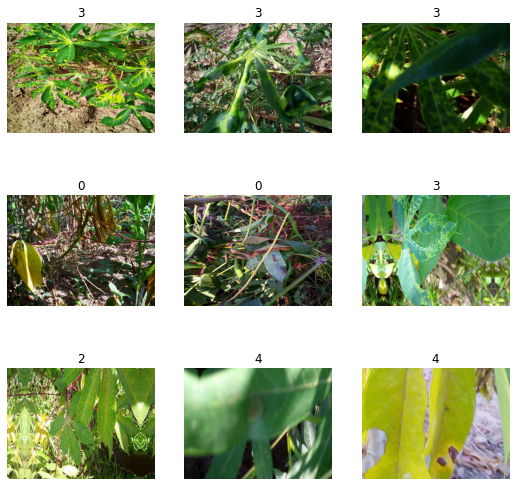

In [9]:
dls.train.show_batch()

## 2. Model
Learn a model to classify a given image into these 4 disease categories or a 5th category indicating a healthy leaf, using the images in the training data

### 2.0 Pretrained model offline

In [10]:
#src Daniel
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
#$param
#resnet18
#!cp '../input/resnet185c106cdepth/resnet18-5c106cde.pth' '/root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth'
#resnet50
!cp /kaggle/input/fastai-pretrained/resnet50-19c8e357.pth /root/.cache/torch/hub/checkpoints/

### 2.1 Train 
Mini training n_epochs.

In [11]:
torch.cuda.empty_cache()

In [12]:
set_seed(SEED)
#track time
t0 = time.time()

#Ch7 pg251 LabelSmoothingCrossEntropy()
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy) #$param
if MINI:
    learn.fine_tune(N_EPOCHS_MINI) #$param
else:
    learn.fine_tune(N_EPOCHS_FULL) #$param

t1 = time.time()
print ("Training time (in min)", (time.time() - t0)/60)

epoch,train_loss,valid_loss,accuracy,time
0,2.059263,1.430330,0.614486,01:28


epoch,train_loss,valid_loss,accuracy,time
0,1.394301,1.002677,0.747664,01:46
1,1.256723,1.048626,0.726636,01:45
2,1.214208,1.085053,0.750000,01:46
3,1.118608,0.866527,0.808411,01:45
4,1.031530,0.778635,0.829439,01:46
5,0.948984,0.831643,0.806075,01:46
6,0.895151,0.810993,0.815421,01:45
7,0.880858,0.939564,0.848131,01:46
8,0.847924,0.773301,0.831776,01:47
9,0.805390,0.713039,0.857477,01:46


Training time (in min) 28.092298543453218


In [13]:
#save the state of your model
if MINI:
    learn.save('my-mini-res50-std16bs')
else:
    learn.save('my-full-res50-std16bs') #$param
    
#export model
learn.export()

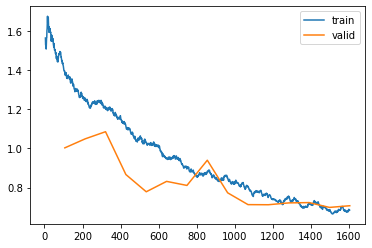

In [14]:
learn.recorder.plot_loss()

### 2.2 Evaluate

In [15]:
#use exports for inference
#learn = load_learner($param path'/export.pkl')

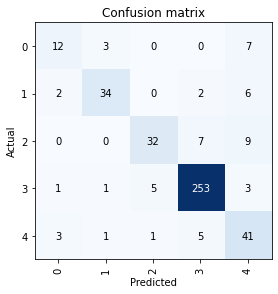

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [17]:
interp.most_confused(min_val=8)

[(2, 4, 9)]

## 3. Predict

In [18]:
#Predict on one file
#view test images - only one
#Image.open(test_img[0])

#predict one, returns a tuple, get 0th item
#y_hat = learn.predict(test_img[0])
#y_hat[0]

Test dataset

In [19]:
#template
sample_submission = pd.read_csv(path/'sample_submission.csv')
submission = sample_submission.copy()

#create test images id
test_img_id = [os.path.join(path/'test_images', x) for x in submission['image_id'].values]

#images in test files
test_img_id

['../input/cassava-leaf-disease-classification/test_images/2216849948.jpg']

In [20]:
test_dl = dls.test_dl(test_img_id)
len(test_dl)

#predict, no TTA
preds,_ = learn.get_preds(dl=test_dl)
#preds

#submission
submission['label'] = preds.argmax(dim=-1).numpy()
submission.head()

,image_id,label
0,2216849948.jpg,4


## 4. Submit


In [21]:
submission.to_csv('submission.csv', index=False)
